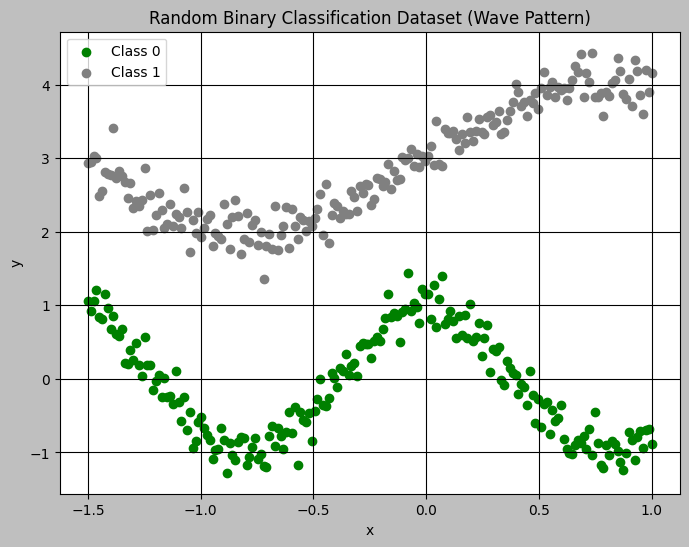

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(plt.style.available[10])

# Set the random seed for reproducibility
np.random.seed(42)

# Generate x-coordinates for both classes
x = np.linspace(-1.5, 1, 200)

# Generate y-coordinates for class 0 (lower wave)
y0 = np.cos(4 * x) + np.random.normal(0, 0.2, 200)

# Generate y-coordinates for class 1 (upper wave)
y1 = np.sin(2 * x) + np.random.normal(3, 0.2, 200)

# Combine the coordinates into a single dataset
X = np.vstack((np.column_stack((x, y0)), np.column_stack((x, y1))))

# Create labels for the dataset
y = np.hstack((np.zeros(200), np.ones(200)))

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:200, 0], X[:200, 1], color='green', label='Class 0')
plt.scatter(X[200:, 0], X[200:, 1], color='gray', label='Class 1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Random Binary Classification Dataset (Wave Pattern)')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import torch
from smolgrad import Tensor, optims
import smolgrad.nn as nn

In [3]:
# data

X_train = Tensor(X.tolist())
y_train = Tensor(y.tolist())

print("Training data: ", X_train)
print("Training data shape: ", X_train.shape)
print("Labels: ", y_train)
print("Labels shape: ", y_train.shape)

Training data:  Tensor(array([[-1.5, 1.05951],
       [-1.48744, 0.91727],
       [-1.47487, 1.05683],
       ...,
       [0.974874, 4.19983],
       [0.987437, 3.89656],
       [1, 4.15686]], dtype=float32), is_mlx_tensor=True)
Training data shape:  (400, 2)
Labels:  Tensor(array([0, 0, 0, ..., 1, 1, 1], dtype=float32), is_mlx_tensor=True)
Labels shape:  (400,)


In [4]:
# learning rate, loss function, and optimizer

lr = 0.009
epochs = 450

In [5]:
# setup wandb
import wandb

wandb.init(
    project="smolgrad-vs-torch",
    config={
        "learning_rate": lr,
        "epochs": epochs
    },
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maharshipandya (sedlyf). Use `wandb login --relogin` to force relogin


In [6]:
import tqdm
import time

In [7]:
def train_model(
    model, X_train, y_train,
    loss_fn, optim, epochs, which_run = "smolgrad"
):
    loop = tqdm.tqdm(range(epochs))
    losses = []

    start = time.time()
    for epoch in loop:
        y_pred = model(X_train).reshape(-1)
        loss: Tensor = loss_fn(y_pred, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossval = loss.data.item()

        losses.append(lossval)
        loop.set_postfix(loss=lossval)
        
        wandb.log({"loss": lossval})

    end = time.time()
    print(f"Finished {which_run} training in {end - start} seconds...") 

In [8]:
# create smolgrad model

in_feats, out_feats = 2, 1

sg_model = nn.Sequential(
    nn.Linear(in_feats, 5),
    nn.ReLU(),
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, out_feats),
    nn.Sigmoid()    
)

sg_loss_fn = nn.BCELoss()
sg_optim = optims.SGD(sg_model.parameters(), lr=lr)

len(sg_model.parameters())

6

In [9]:
# create pytorch model
device = "mps" if torch.backends.mps.is_available() else "cpu"
pt_model = torch.nn.Sequential(
    torch.nn.Linear(in_feats, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, out_feats),
    torch.nn.Sigmoid()    
).to(device)

pt_loss_fn = torch.nn.BCELoss()
pt_optim = torch.optim.SGD(pt_model.parameters(), lr=lr)

len = 0
for p in pt_model.parameters():
    len += 1

print(len)

6


In [10]:
train_model(sg_model, X_train, y_train, sg_loss_fn, sg_optim, epochs)
train_model(pt_model, torch.Tensor(X.tolist()).to(device), torch.Tensor(y.tolist()).to(device), pt_loss_fn, pt_optim, epochs, which_run="pytorch")

  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 450/450 [00:00<00:00, 513.71it/s, loss=0.125]


Finished smolgrad training in 0.8762707710266113 seconds...


100%|██████████| 450/450 [00:01<00:00, 410.48it/s, loss=0.402]

Finished pytorch training in 1.0965392589569092 seconds...
